# **Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from collections import Counter
import plotly.graph_objects as go
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# **Data Sources**

In [ ]:
!7z e train.tsv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 77912192 bytes (75 MiB)

Extracting archive: train.tsv.7z
--
Path = train.tsv.7z
Type = 7z
Physical Size = 77912192
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./train.tsv
  Size:     337809843 bytes (323 MiB)
  Modified: 2017-11-11 01:31:09
with the file from archive:
  Path:     train.tsv
  Size:     337809843 bytes (323 MiB)
  Modified: 2017-11-11 01:31:09
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [ ]:
df=pd.read_csv('/content/drive/My Drive/Kaggle/Mercari/train.tsv',sep='\t', header=0)
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
df.shape

(1482535, 8)

# **Basic Data Analysis**

In [ ]:
(df.isnull().sum()/df.shape[0])*100

train_id              0.000000
name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000270
dtype: float64

**Observatoins**

*   About 42.67 % products have missing values for brand_name which is quite significant
*   About .42 % products have missing values for Category name
*   Less than 0.1 % of products have missing values for item description






In [ ]:
df['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

In [ ]:
df['shipping'].unique()

array([1, 0])

In [ ]:
df['brand_name'].nunique()

4809

In [ ]:
df['category_name'].nunique()

1287

In [ ]:
df['name'].nunique()

1225273

# **EDA**

## **Missing_values**

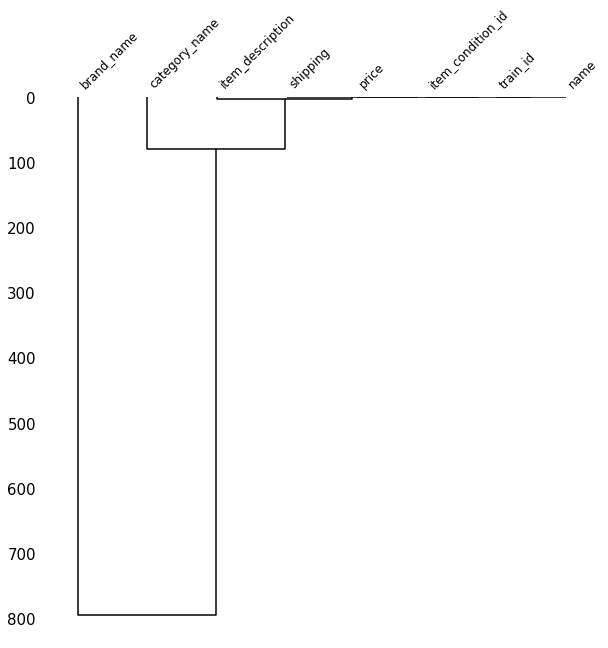

In [ ]:
import missingno as msno
msno.dendrogram(df, inline=True, fontsize=12, figsize=(10,10))

**Observations**

*   There are missing values for features Category_name, brand_name and item_description and the missing values for features are independent of each other
*   These missing values can be replaced as 'Unkown' 

In [ ]:
df['category_name']=np.where(df['category_name'].isnull(),'Unknown_Category',df['category_name'])
df['brand_name']=np.where(df['brand_name'].isnull(),'Unknown_Brand',df['brand_name'])
df['item_description']=np.where(df['item_description'].isnull(),'Unknown_description',df['item_description'])

## **Analysis of Price**

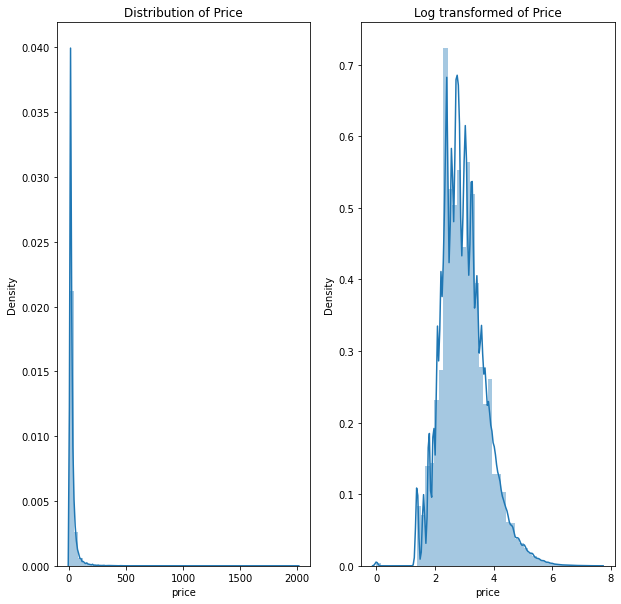

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.subplot(1,2,1)
sns.distplot(df['price'],kde=True ,bins=50)
plt.title('Distribution of Price')

plt.subplot(1,2,2)
sns.distplot(np.log(df['price']+1),kde=True ,bins=50)
plt.title('Log transformed of Price')

plt.show()

**Observation**

*   The price distribution is right skewed
*   It can be normalized using log transformation



In [ ]:
df['log_price']=np.log1p(df['price']+1)

Text(0.5, 1.0, 'CDF of Price')

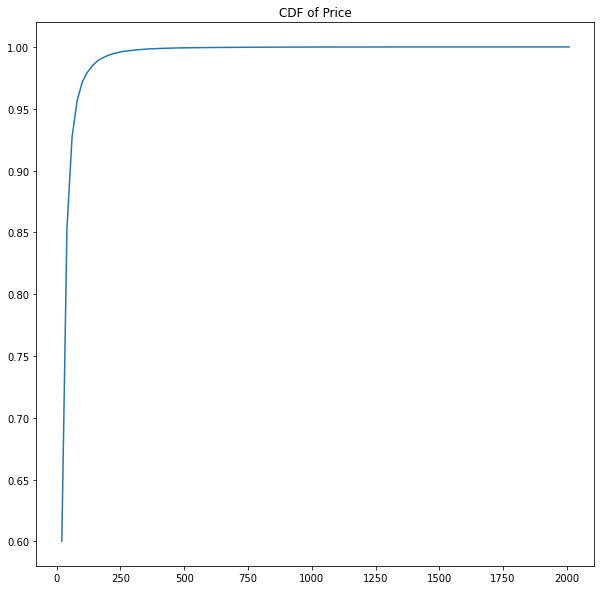

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
counts, bin_edges = np.histogram(df['price'], bins=100, 
                                 density = True)
pdf = counts/(sum(counts))
cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:], cdf)
plt.title('CDF of Price')


**Observation**

*   From the CDF it can be seen that more than 95% of the products are priced below 250$






In [ ]:
df_free=df[df['price']==0.0].copy()
df_free.shape

In [ ]:
categories=df_free['category_name'].value_counts()
categories.sort_values(ascending=False).head()

In [ ]:
x = categories[:5].index
y =categories[:5].values
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )] )

fig.update_layout(title='Top 5 categories with Free Products')
fig.update_xaxes(title_text='Categories')
fig.update_yaxes(title_text='Price')
fig.show()

**Observations**

*   The top 5 free products offered belog to women apprel and beauty products 




In [ ]:
brands=df_free['brand_name'].value_counts()
brands.sort_values(ascending=False).head()

In [ ]:
x = brands[:5].index
y =brands[:5].values

fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])
fig.update_layout(title='Top 5 brands with Free Products')
fig.update_xaxes(title_text='Brands')
fig.update_yaxes(title_text='No. Of Products')
fig.show()

**Observations**

*   The topmost free product offerings are by unknown brand which has been imputed i.e brand name missing



## **Analysis on Shipping**

In [ ]:
df.groupby('shipping').size()/df.shape[0]

shipping
0    0.552726
1    0.447274
dtype: float64

**observations**

*   More than 55% of products are shipped by Buyers




In [ ]:
df.groupby('shipping')['price'].mean()

shipping
0    30.111778
1    22.567726
Name: price, dtype: float64

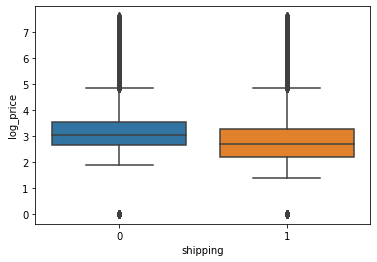

In [ ]:
sns.boxplot(x='shipping',y='log_price',data=df )

**Observations**

*   As per the above plots mean values for products shipped by buyer are priced higher than the one shipped by the seller. Lets further investigate by using the actual percentile values as below.



In [ ]:
df.groupby('shipping')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
shipping,,,,,,,,
0,819435.0,30.111778,39.53592,0.0,13.0,20.0,33.0,2009.0
1,663100.0,22.567726,36.95579,0.0,8.0,14.0,25.0,2000.0


**Observations**

*   The mean price for products for which shipping cost  is paid by buyer is higher than the ones by seller 
*   All the percentile of price for products for which shipping cost  is paid by buyer is higher than the ones by seller 
*   From the above analysis it can be concluded that price for products for which shipping cost  is paid by buyer is higher than otherwise




## **Analysis on Item Condition ID**

In [ ]:
df.groupby('item_condition_id').size()/df.shape[0]

item_condition_id
1    0.432063
2    0.253268
3    0.291501
4    0.021559
5    0.001608
dtype: float64

**Observations**

*   More than 43% of products belong to item_condition_id =1
*   Less than 1% of products belong to item_condition_id=5



In [ ]:
df.groupby('item_condition_id')['price'].mean()

item_condition_id
1    26.486967
2    27.563225
3    26.540711
4    24.349212
5    31.703859
Name: price, dtype: float64

**Observations**

*   The avg price for products with item_condition_id=5 is maximum
*   The avg price for products with item_condition_id '1' and '3' is similar 



In [ ]:
df.groupby('item_condition_id')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
1,640549.0,26.486967,35.418024,0.0,10.0,18.0,30.00,2009.0
2,375479.0,27.563225,42.125698,0.0,11.0,17.0,29.00,2004.0
3,432161.0,26.540711,40.030681,0.0,11.0,16.0,28.00,2000.0
4,31962.0,24.349212,35.679148,0.0,10.0,15.0,26.00,1309.0
5,2384.0,31.703859,39.531069,0.0,11.0,19.0,35.25,522.0


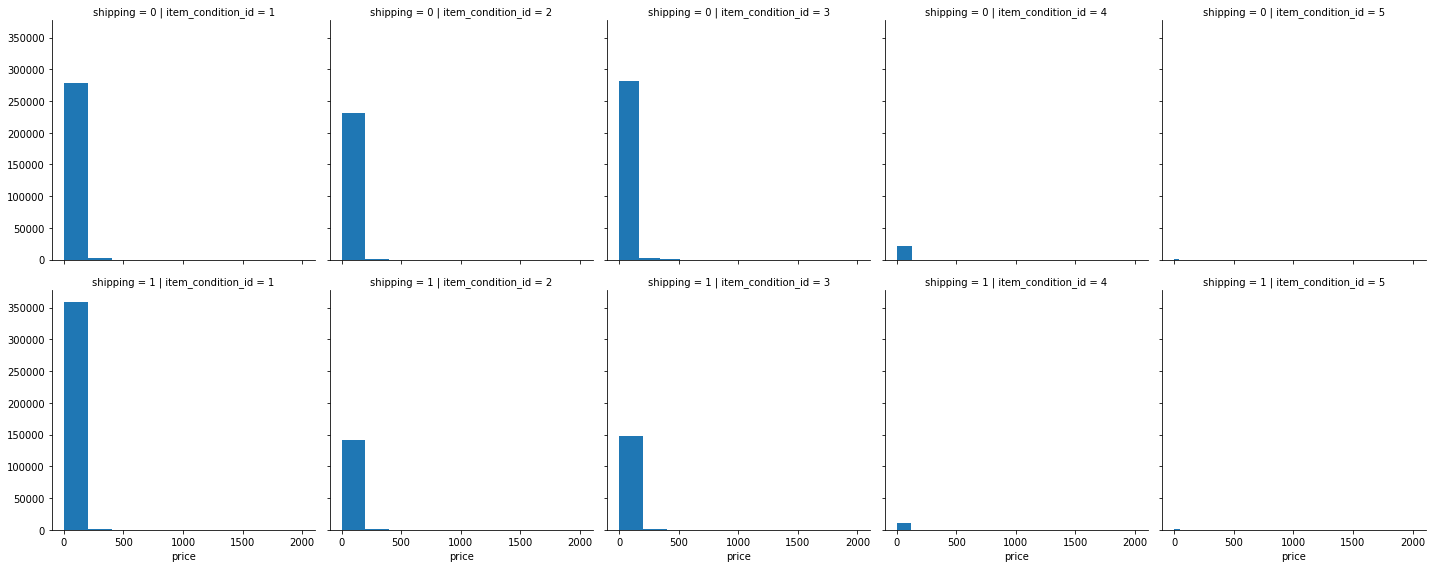

In [ ]:
g = sns.FacetGrid(df, row="shipping",  col = "item_condition_id" , height=4)
g = g.map(plt.hist, "price")

**Observations**

*   The  maximum price of products shipped by seller with condition id '1' is higher than that of shipped by Buyer
*   The  maximum price of products shipped by seller with condition id '2' , '3' and '4' is Lower than that of shipped by Buyer



## **Analysis on Brands**

In [ ]:
brands=df['brand_name'].value_counts()
brands.sort_values(ascending=False).head()

Unknown_Brand        632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64

In [ ]:
x = brands[:15].index
y =brands[:15].values
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(title='Top 15 Brands with highest number of Products')
fig.update_xaxes(title_text='Brands')
fig.update_yaxes(title_text='No. Of Products')
fig.show()

**Observations**

*   The top 5 brands contribute to more than 10% of products offered by Mercari




In [ ]:
brands_price=df.groupby('brand_name')['price'].mean().astype(int)
brands_price=brands_price.sort_values(ascending=False)

In [ ]:
brands_price.shape

(4810,)

In [ ]:
x = brands_price[:15].index
y =brands_price[:15].values
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(title='Top 15 Expensive Brands')
fig.update_xaxes(title_text='Brands')
fig.update_yaxes(title_text='Avg Price')
fig.show()

**Observations**

*   The most expensive brand by mean price is Demdaco with avg price about 429 $




## **Analysis on Category**

In [ ]:
cat=df['category_name'].value_counts()
cat.sort_values(ascending=False).head()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

**Observations**

The Categories are divided into multiple levels using '/' as delimiter

In [ ]:
df.category_name.str.count('/').max()

4

**Observation**

As seen the maximum number of '/' delimiter in a string is 4 there are 5 category levels 

In [ ]:
df[['category1','category2','category3','category4','category5']]=df['category_name'].str.split('/',n=-1,expand=True)

In [ ]:
df['category1']=np.where(df['category1'].isnull(),'undefined',df['category1'])
df['category2']=np.where(df['category2'].isnull(),'undefined',df['category2'])
df['category3']=np.where(df['category3'].isnull(),'undefined',df['category3'])
df['category4']=np.where(df['category4'].isnull(),'undefined',df['category4'])
df['category5']=np.where(df['category5'].isnull(),'undefined',df['category5'])

In [ ]:
df['category_name']=df['category_name'].str.replace('/'," ")

In [ ]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,category1,category2,category3,category4,category5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men Tops T-shirts,Unknown_Brand,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,undefined,undefined
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics Computers & Tablets Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,undefined,undefined
2,2,AVA-VIV Blouse,1,Women Tops & Blouses Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,undefined,undefined
3,3,Leather Horse Statues,1,Home Home Décor Home Décor Accents,Unknown_Brand,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,undefined,undefined
4,4,24K GOLD plated rose,1,Women Jewelry Necklaces,Unknown_Brand,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,undefined,undefined


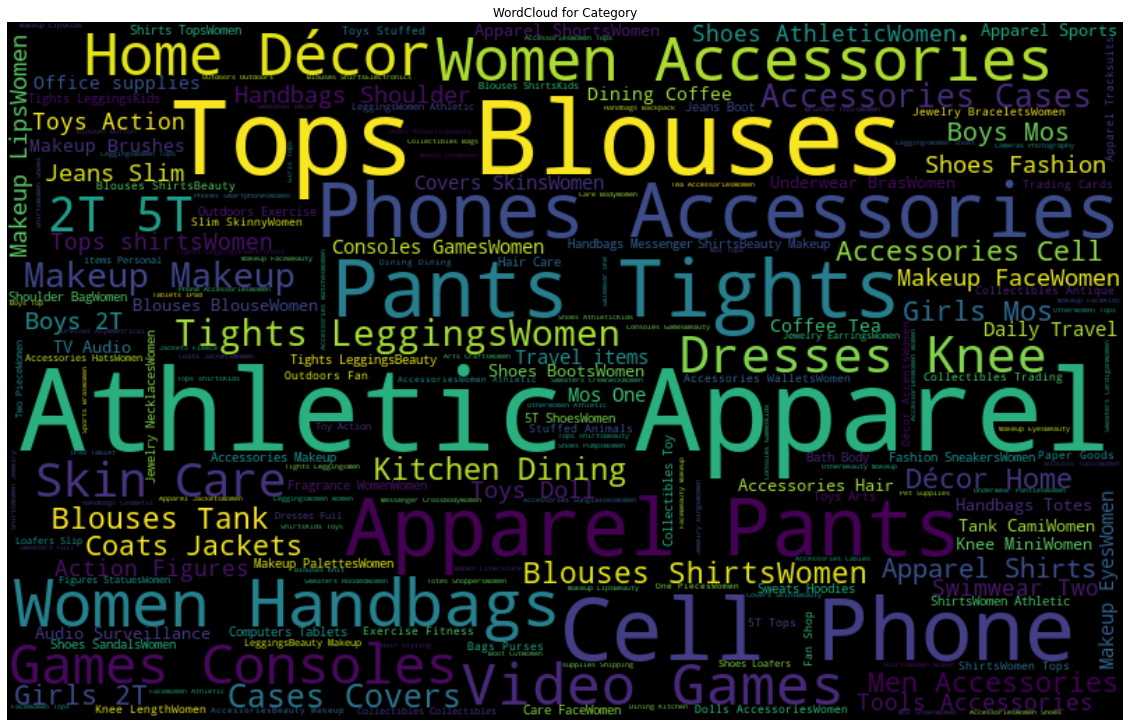

In [ ]:
txt=df.category_name.values.astype(str)
txt_string=''

for i in txt:
  txt_string+= str(i)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(txt_string)

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for Category')
plt.show()

**Observations**

Most of the words in category world cloud appear to be related with women accessories

In [ ]:
cat=df.groupby('category1').size()
cat=cat.sort_values(ascending=False)

In [ ]:
x = cat.index
y =cat.values
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(title='Categories with number of Products')
fig.update_xaxes(title_text='Categories')
fig.update_yaxes(title_text='No. Of Products')
fig.show()

**Observations**

*   The Top 2 product categories is dominated by women apparels and make up products 
*   The category for products related to sports and outdoors has the least number of products  






In [ ]:
df.groupby('category1')['price'].describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
category1,,,,,,,,
Beauty,207828,19,21,0,10,15,24,2000
Electronics,122690,35,65,0,9,15,31,1909
Handmade,30842,18,27,0,6,12,20,1750
Home,67871,24,24,0,12,18,29,848
Kids,171689,20,22,0,10,14,24,809
Men,93680,34,41,0,14,21,40,1309
Other,45351,20,29,0,9,14,23,1400
Sports & Outdoors,25342,25,29,0,11,16,28,915
Unknown_Category,6327,25,34,0,10,16,28,1000


In [ ]:
cat_price=df.groupby('category1')['price'].mean().astype(int)
cat_price=cat_price.sort_values(ascending=False)

In [ ]:
x = cat_price.index
y =cat_price.values
fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(title='Avg price for each category')
fig.update_xaxes(title_text='Category')
fig.update_yaxes(title_text='Price')
fig.show()

**Observations**

*   The average price for electronics products is the highest 
*   Handmade products have the lowest average price 



## **Analysis Product Name**

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
def preprocess_txt(data):
    preprocessed = []
    # tqdm is for printing the status bar
    for sentance in data:
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [ ]:
df['product_name_preprocessed']=preprocess_txt(df['name'])

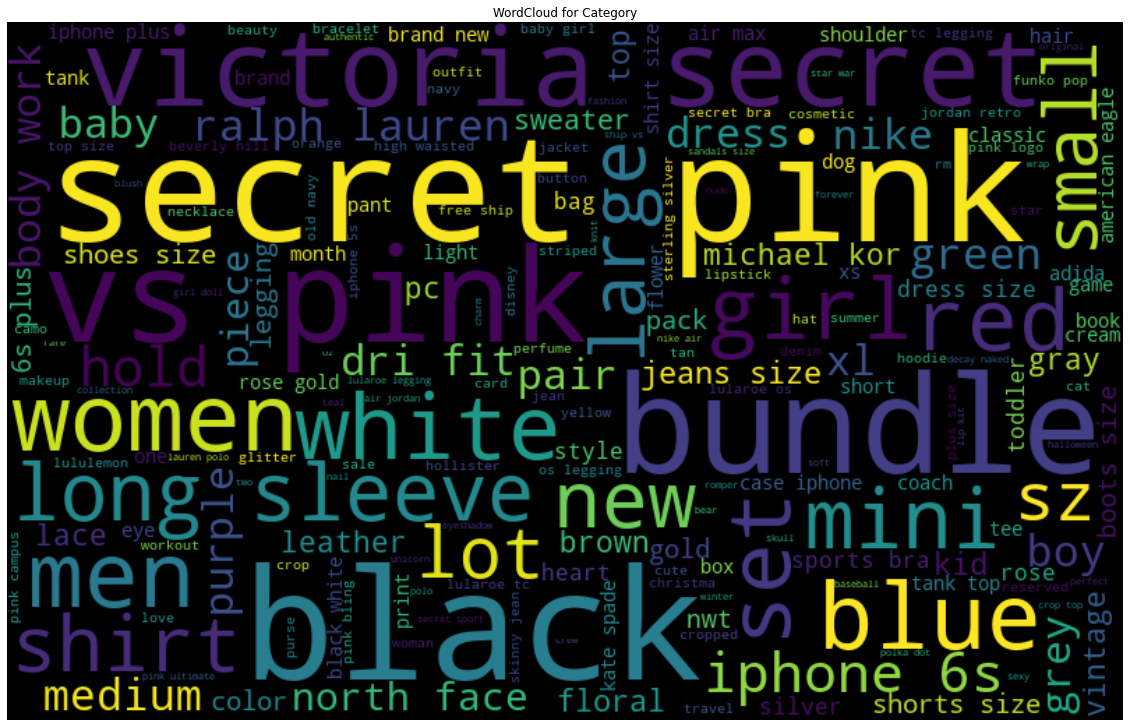

In [ ]:

txt=df.product_name_preprocessed.values.astype(str)
txt_string=''

for i in txt:
  txt_string+= str(i)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(txt_string)

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for Category')
plt.show()

**Observations**

From the word cloud we can sense that most of the product names represent associated brand names 




In [ ]:
from nltk import bigrams
from collections import Counter
counter=Counter()
for word in df['product_name_preprocessed'].astype(str).values:
  counter.update(bigrams(word.split(' ')))

product_name_preprocessed_dict=  dict(counter)

In [ ]:
bigrams=pd.DataFrame(product_name_preprocessed_dict.items(), columns=['bigrams', 'freq'])
bigrams.sort_values(ascending=False,by='freq',inplace=True)
top_20=bigrams[:20]

Text(0.5, 1.0, 'Top 20 Bigrams for Product Name')

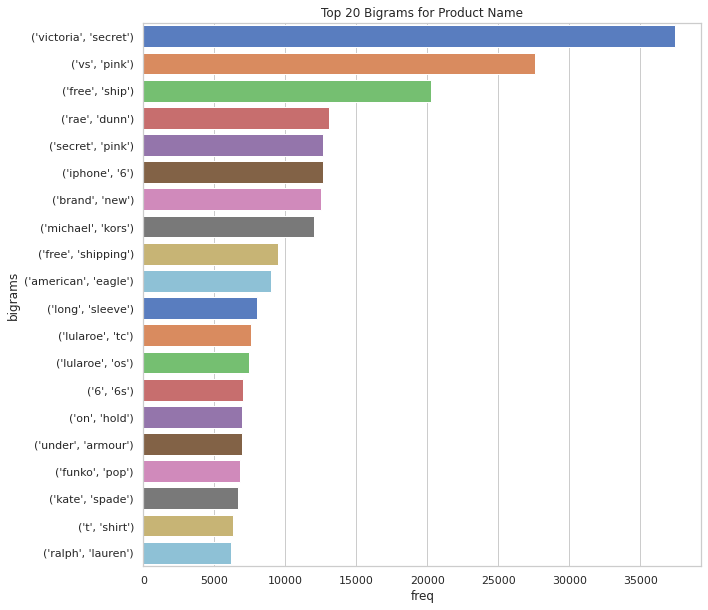

In [ ]:
sns.set(rc={'figure.figsize':(10,10)}, style = 'whitegrid')
sns.barplot(x = "freq", y="bigrams", data=top_20,palette="muted")
plt.title('Top 20 Bigrams for Product Name')

**Observation**

As also observed in the word cloud we can now be very sure that Product names have high frequency of Brand names 

## **Analysis on Product Description**

In [ ]:
df['item_description_preprocessed']=preprocess_txt(df['item_description'].astype(str))

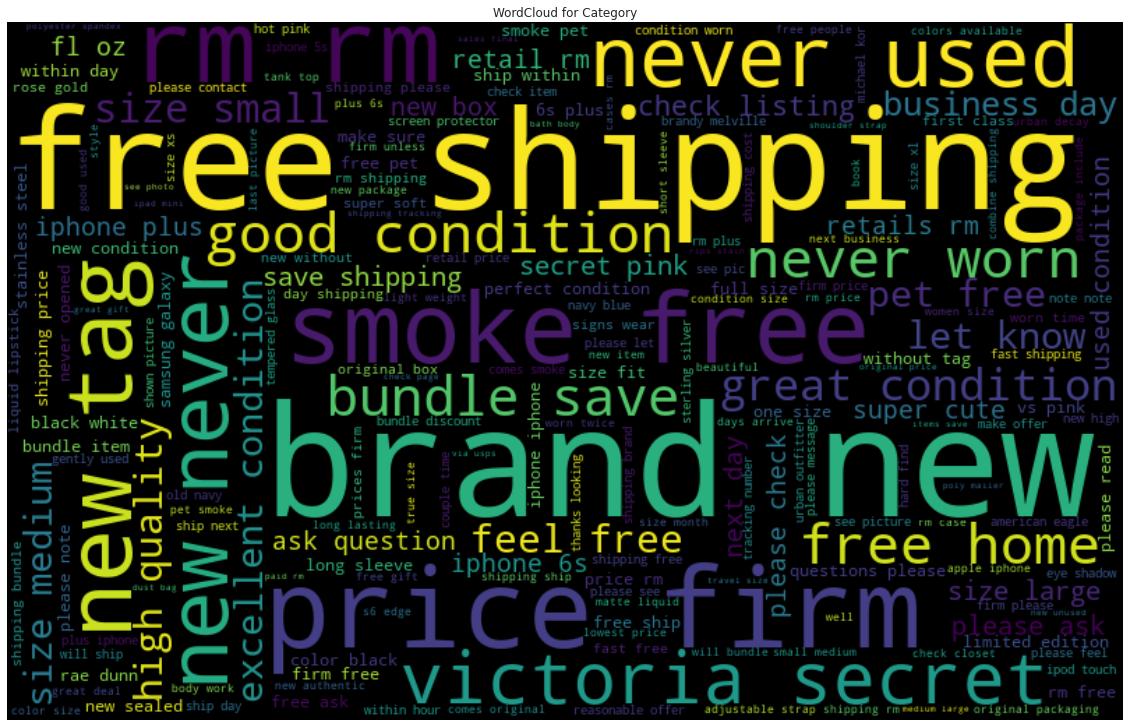

In [ ]:
txt=df['item_description_preprocessed'][:500000].values.astype(str)
txt_string=''

for i in txt:
  txt_string+= str(i)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(txt_string)

plt.figure(figsize=(20, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for Category')
plt.show()

**Observation**

The description about products is highlighting the condition of the product , shipping information ,brand etc about the product which can be key to predict the price .

In [ ]:
len_desc=df.groupby('desc_length')['price'].max()
len_desc=len_desc.sort_index(ascending=False)
len_desc.head()

desc_length
991    293.0
988      8.0
982      4.0
981     25.0
978     15.0
Name: price, dtype: float64

In [ ]:
len_desc.tail()

desc_length
4    656.0
3    559.0
2    195.0
1    200.0
0    224.0
Name: price, dtype: float64

**Observation**

From the above tables it can be seen that the length of the description of the product is not directly related to the price 

In [ ]:
from nltk import bigrams
from collections import Counter
counter=Counter()
for word in df['item_description_preprocessed'].astype(str).values:
  counter.update(bigrams(word.split(' ')))

item_description_preprocessed_dict=  dict(counter)

In [ ]:
bigram=pd.DataFrame(item_description_preprocessed_dict.items(), columns=['bigram', 'freq'])
bigram.sort_values(ascending=False,by='freq',inplace=True)

In [ ]:
top_20=bigram[:20]

Text(0.5, 1.0, 'Top 20 Bigrams for Product Description')

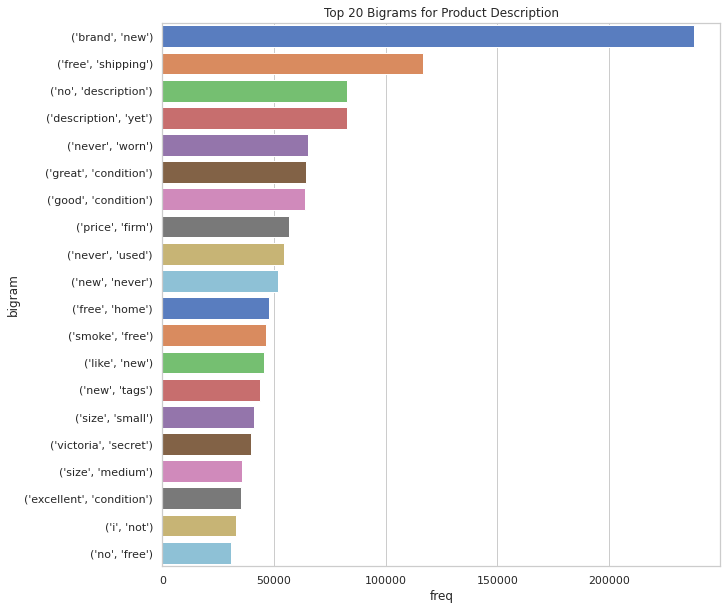

In [ ]:
sns.barplot(x = "freq", y="bigram", data=top_20,palette="muted")
plt.title('Top 20 Bigrams for Product Description')

**Observations:**
From the bigram plot it is clear that most frequently occuring words such as 'brand new' ,'excellent_condition' etc attribute to the condition of the product

In [ ]:
from nltk import trigrams
counter=Counter()
for word in df['item_description_preprocessed'].astype(str).values:
  counter.update(trigrams(word.split(' ')))

item_description_preprocessed_dict=  dict(counter)

In [ ]:
trigram=pd.DataFrame(item_description_preprocessed_dict.items(), columns=['trigram', 'freq'])
trigram.sort_values(ascending=False,by='freq',inplace=True)

In [ ]:
top_20=trigram[:20]

Text(0.5, 1.0, 'Top 20 Trigrams for Product Description')

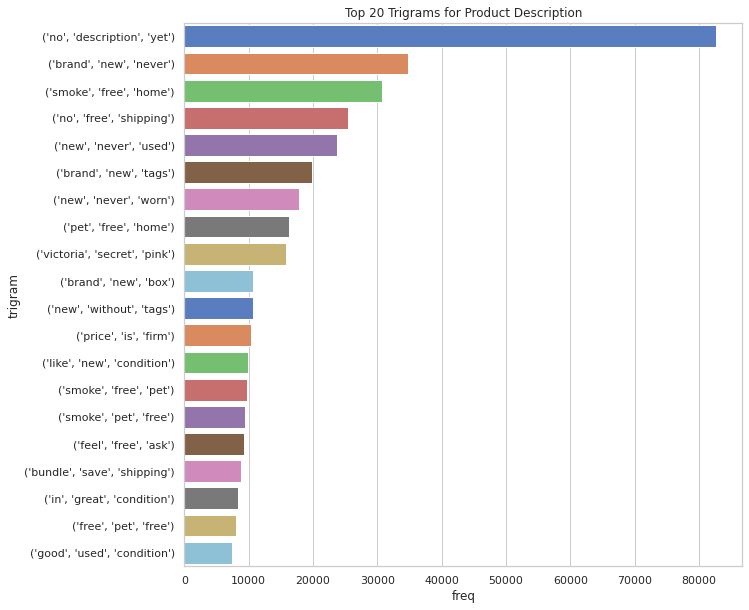

In [ ]:
sns.barplot(x = "freq", y="trigram", data=top_20,palette="muted")
plt.title('Top 20 Trigrams for Product Description')

**Observation:**
From the Trigram plot it appears that more than 80000 products do not have a description 

# **Feature Engineering**

In [ ]:
def basic_text_features(df,column,stopwords):

  df[column]=df[column].astype(str)

  df["No_of_words"+column]=df[column].apply(lambda x : len(str(x).split(" ")))
  df["No_of_chars"+column]=df[column].str.len()
  df['Avg_len_'+column]=df[column].apply(lambda x : (sum(len(word) for word in x.split())/len(x.split())))
  df["No_of_stop_words"+column]=df[column].apply(lambda x: len([x for x in x.split() if x in stopwords]))
  df['No_of_digits'+column]=df[column].apply(lambda x : len([x for x in x.split() if x.isdigit()]))
  df['No_of_upper_cased'+column]=df[column].apply(lambda x : len([x for x in x.split() if x.isupper()]))
  df['No_of_lower_cased'+column]=df[column].apply(lambda x : len([x for x in x.split() if x.islower()]))

  return df


In [ ]:
stop=stopwords
df=basic_text_features(df,"item_description",stop)



In [ ]:
df=basic_text_features(df,"name",stop)

In [ ]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,No_of_wordsitem_description,No_of_charsitem_description,Avg_len_item_description,No_of_stop_wordsitem_description,No_of_digitsitem_description,No_of_upper_caseditem_description,No_of_lower_caseditem_description,No_of_wordsname,No_of_charsname,Avg_len_name,No_of_stop_wordsname,No_of_digitsname,No_of_upper_casedname,No_of_lower_casedname
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Unknown_Brand,10.0,1,No description yet,2.397895,3,18,5.333333,0,0,0,2,7,35,4.142857,0,0,3,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,36,188,4.250000,15,0,1,30,4,32,7.250000,0,0,0,0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,29,124,3.310345,13,0,3,24,2,14,6.500000,0,0,1,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Unknown_Brand,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,32,173,4.437500,10,0,0,24,3,21,6.333333,0,0,0,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Unknown_Brand,44.0,0,Complete with certificate of authenticity,3.806662,5,41,7.400000,2,0,0,4,4,20,4.250000,0,0,2,2


In [ ]:
(df.isnull().sum()/df.shape[0])*100

train_id                             0.0
name                                 0.0
item_condition_id                    0.0
category_name                        0.0
brand_name                           0.0
price                                0.0
shipping                             0.0
item_description                     0.0
log_price                            0.0
No_of_wordsitem_description          0.0
No_of_charsitem_description          0.0
Avg_len_item_description             0.0
No_of_stop_wordsitem_description     0.0
No_of_digitsitem_description         0.0
No_of_upper_caseditem_description    0.0
No_of_lower_caseditem_description    0.0
No_of_wordsname                      0.0
No_of_charsname                      0.0
Avg_len_name                         0.0
No_of_stop_wordsname                 0.0
No_of_digitsname                     0.0
No_of_upper_casedname                0.0
No_of_lower_casedname                0.0
dtype: float64

In [ ]:
df['Combined_text']=df['name']+df['category_name']+df['brand_name']+df['item_description']

# **Save Data after preprocessing and Basic Featurization**

In [ ]:
df=df[df['price']>3].copy()

In [ ]:
df=df[df['price']<2000].copy()

In [ ]:
df.shape

(1462949, 30)

In [ ]:
y = df['log_price'].values
df.drop(['log_price'], axis=1, inplace=True)

X = df

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
X_train['combined_text_preprocessed']=preprocess_txt(X_train['Combined_text'].astype(str))
X_test['combined_text_preprocessed']=preprocess_txt(X_test['Combined_text'].astype(str))

In [ ]:
with open('/content/drive/My Drive/Kaggle/Mercari/approach_1/X_train.pkl','wb') as f:
     pickle.dump(X_train, f)

with open('/content/drive/My Drive/Kaggle/Mercari/approach_1/X_test.pkl','wb') as f:
     pickle.dump(X_test, f)     

with open('/content/drive/My Drive/Kaggle/Mercari/approach_1/y_train.pkl','wb') as f:
     pickle.dump(y_train, f)

with open('/content/drive/My Drive/Kaggle/Mercari/approach_1/y_test.pkl','wb') as f:
     pickle.dump(y_test, f)   

In [ ]:
with open('/content/drive/My Drive/Kaggle/Mercari/approach_1/X.pkl','wb') as f:
     pickle.dump(X, f) 